In [2]:
# Loading libraries:

from datetime import datetime
import numpy as np
from numpy import random
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, KFold
import xgboost
import glob
import os

### DATA PROCESSING:

In [8]:
# Compiling data from sub-datasets:

file_path = r'/Users/vince.dang/Desktop/SMU_MITB/CS610 Applied Machine Learning/Project/house_price'
file_list = os.listdir(file_path)
csv_files = list(filter(lambda f: f.startswith('resale-flat-prices'), file_list))
csv_files

['resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv',
 'resale-flat-prices-based-on-approval-date-1990-1999.csv',
 'resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv',
 'resale-flat-prices-based-on-approval-date-2000-feb-2012.csv',
 'resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv']

In [47]:
# Get interest rate data:
int_rate = pd.read_excel(file_path + '/sg int.xlsx')
int_rate['Date'] = pd.to_datetime(int_rate['Date'])
int_rate['year'] = int_rate['Date'].dt.year

def find_quarter(value):
    if value <= 3:
        return 1
    elif value <= 6:
        return 2
    elif value <= 9:
        return 3
    else:
        return 4
int_rate['quarter'] = int_rate['Date'].dt.month.map(find_quarter)
int_rate.rename(columns = {'Ask Price':'interest_rate'}, inplace = True)
min(int_rate['Date'])

Timestamp('1999-09-30 00:00:00')

In [39]:
# Load price index data:
price_ind = pd.read_csv(file_path + '/price_index.csv')
price_ind.head(2)

,year,quarter,price_index
0,2022,4,171.9
1,2022,3,168.1


In [10]:
# Get resale data and process time column
df_resale = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)


<bound method DataFrame.info of           month        town         flat_type block        street_name  \
0       2012-03  ANG MO KIO            2 ROOM   172   ANG MO KIO AVE 4   
1       2012-03  ANG MO KIO            2 ROOM   510   ANG MO KIO AVE 8   
2       2012-03  ANG MO KIO            3 ROOM   610   ANG MO KIO AVE 4   
3       2012-03  ANG MO KIO            3 ROOM   474  ANG MO KIO AVE 10   
4       2012-03  ANG MO KIO            3 ROOM   604   ANG MO KIO AVE 5   
...         ...         ...               ...   ...                ...   
894016  2016-12      YISHUN            5 ROOM   297       YISHUN ST 20   
894017  2016-12      YISHUN            5 ROOM   838       YISHUN ST 81   
894018  2016-12      YISHUN         EXECUTIVE   664       YISHUN AVE 4   
894019  2016-12      YISHUN         EXECUTIVE   325        YISHUN CTRL   
894020  2016-12      YISHUN  MULTI-GENERATION   666       YISHUN AVE 4   

       storey_range  floor_area_sqm        flat_model  lease_commence_date  \
0

In [17]:
print(len(df_resale.columns))
print(df_resale.columns)
print(min(df_resale['month']))
print(max(df_resale['month']))
df_resale['resale_price'].describe()

11
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'remaining_lease'],
      dtype='object')
1990-01
2023-02


count    8.940210e+05
mean     3.110768e+05
std      1.622894e+05
min      5.000000e+03
25%      1.900000e+05
50%      2.900000e+05
75%      4.050000e+05
max      1.418000e+06
Name: resale_price, dtype: float64

In [35]:
df_resale['town'].nunique()

27

In [40]:
df_resale['year'] = df_resale['month'].map(lambda x: int(str(x)[:4]))
df_resale['month'] = df_resale['month'].map(lambda x: int(str(x)[-2:]))
df_resale['remaining_lease'] = (99 - df_resale['year'] + df_resale['lease_commence_date'])
df_resale['quarter'] = df_resale['month'].map(find_quarter)
df_resale['month_count'] = df_resale['year']*12 + df_resale['month'] - (1999*12 + 3) #starting from Mar 1999

df_resale = df_resale[df_resale['month_count'] >= 0]

df_resale.tail(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,quarter,month_count
894019,12,YISHUN,EXECUTIVE,325,YISHUN CTRL,01 TO 03,146.0,Maisonette,1988,575000.0,71,2016,4,213
894020,12,YISHUN,MULTI-GENERATION,666,YISHUN AVE 4,10 TO 12,164.0,Multi Generation,1987,735000.0,70,2016,4,213


- Drop 'year' column because the time gap has been recorded by 'month_count' column, which counts the number of months from the starting time (Mar 1999) to the month/year that the house was resale
- Keep 'month' and 'quarter' columns to analyse if there is any seasonal sale pattern within a year
- Drop 'lease_commence_date' column because 'remaining_lease' at the point of sale is a better factor affecting the price

In [42]:
# Combine resale data, interest rate and price index data together
all_data = pd.merge(
    df_resale,
    int_rate[['year', 'quarter', 'interest_rate']],
    how="inner",
    on=['year', 'quarter']
    ).merge(
    price_ind[['year', 'quarter', 'price_index']], 
    how="inner",
    on=['year', 'quarter'])

all_data.tail(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,quarter,month_count,interest_rate,price_index
626864,12,YISHUN,EXECUTIVE,325,YISHUN CTRL,01 TO 03,146.0,Maisonette,1988,575000.0,71,2016,4,213,0.96868,134.6
626865,12,YISHUN,MULTI-GENERATION,666,YISHUN AVE 4,10 TO 12,164.0,Multi Generation,1987,735000.0,70,2016,4,213,0.96868,134.6


In [54]:
print(all_data[(all_data['year']== 2014)&(all_data['month']== 12)]['month_count'].unique())
print(all_data[(all_data['year']== 2015)&(all_data['month']== 1)]['month_count'].unique())
print(all_data[(all_data['year']== 2019)&(all_data['month']== 12)]['month_count'].unique())
print(all_data[(all_data['year']== 2019)&(all_data['month']== 12)]['month_count'].unique())

[189]
[190]
[249]


In [45]:
all_data[['interest_rate', 'price_index']].describe()

,interest_rate,price_index
count,626866.000000,626866.000000
mean,1.428537,106.719343
std,0.969077,31.364383
min,0.373330,69.100000
25%,0.586500,75.300000
50%,1.062500,101.400000
75%,2.250000,134.700000
max,4.250000,171.900000


In [353]:
#Drop year, month columns because we have quarter and month_count columns to represent time and season
# Drop lease_commence_date and use remaining_lease instead
all_data = all_data.drop(['year', 'month', 'lease_commence_date'], axis=1)
all_data.head(2)

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,remaining_lease,quarter,month_count,Ask Price,price_index
0,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,250000.0,73,1,156,0.39494,138.5
1,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,265000.0,67,1,156,0.39494,138.5


In [57]:
all_data[all_data['month_count'] > 221]['resale_price'].mean()

480003.31362582627

In [393]:
print("Dataset columns: ", list(all_data))

print("\nCount number of unique values for each column:\n", all_data.nunique())

print("\nCheck if there is any missing data: \n", all_data.isnull().sum())

print('Total number of rows: ', len(all_data))

Dataset columns:  ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease', 'year', 'quarter', 'month_count', 'Ask Price', 'price_index']

Count number of unique values for each column:
 month                    12
town                     26
flat_type                 8
block                  2644
street_name             578
storey_range             25
floor_area_sqm          192
flat_model               33
lease_commence_date      54
resale_price           7867
remaining_lease          58
year                     24
quarter                   4
month_count             282
Ask Price                80
price_index              82
dtype: int64

Check if there is any missing data: 
 month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_comm

### Visualised relationship among continuous variables:

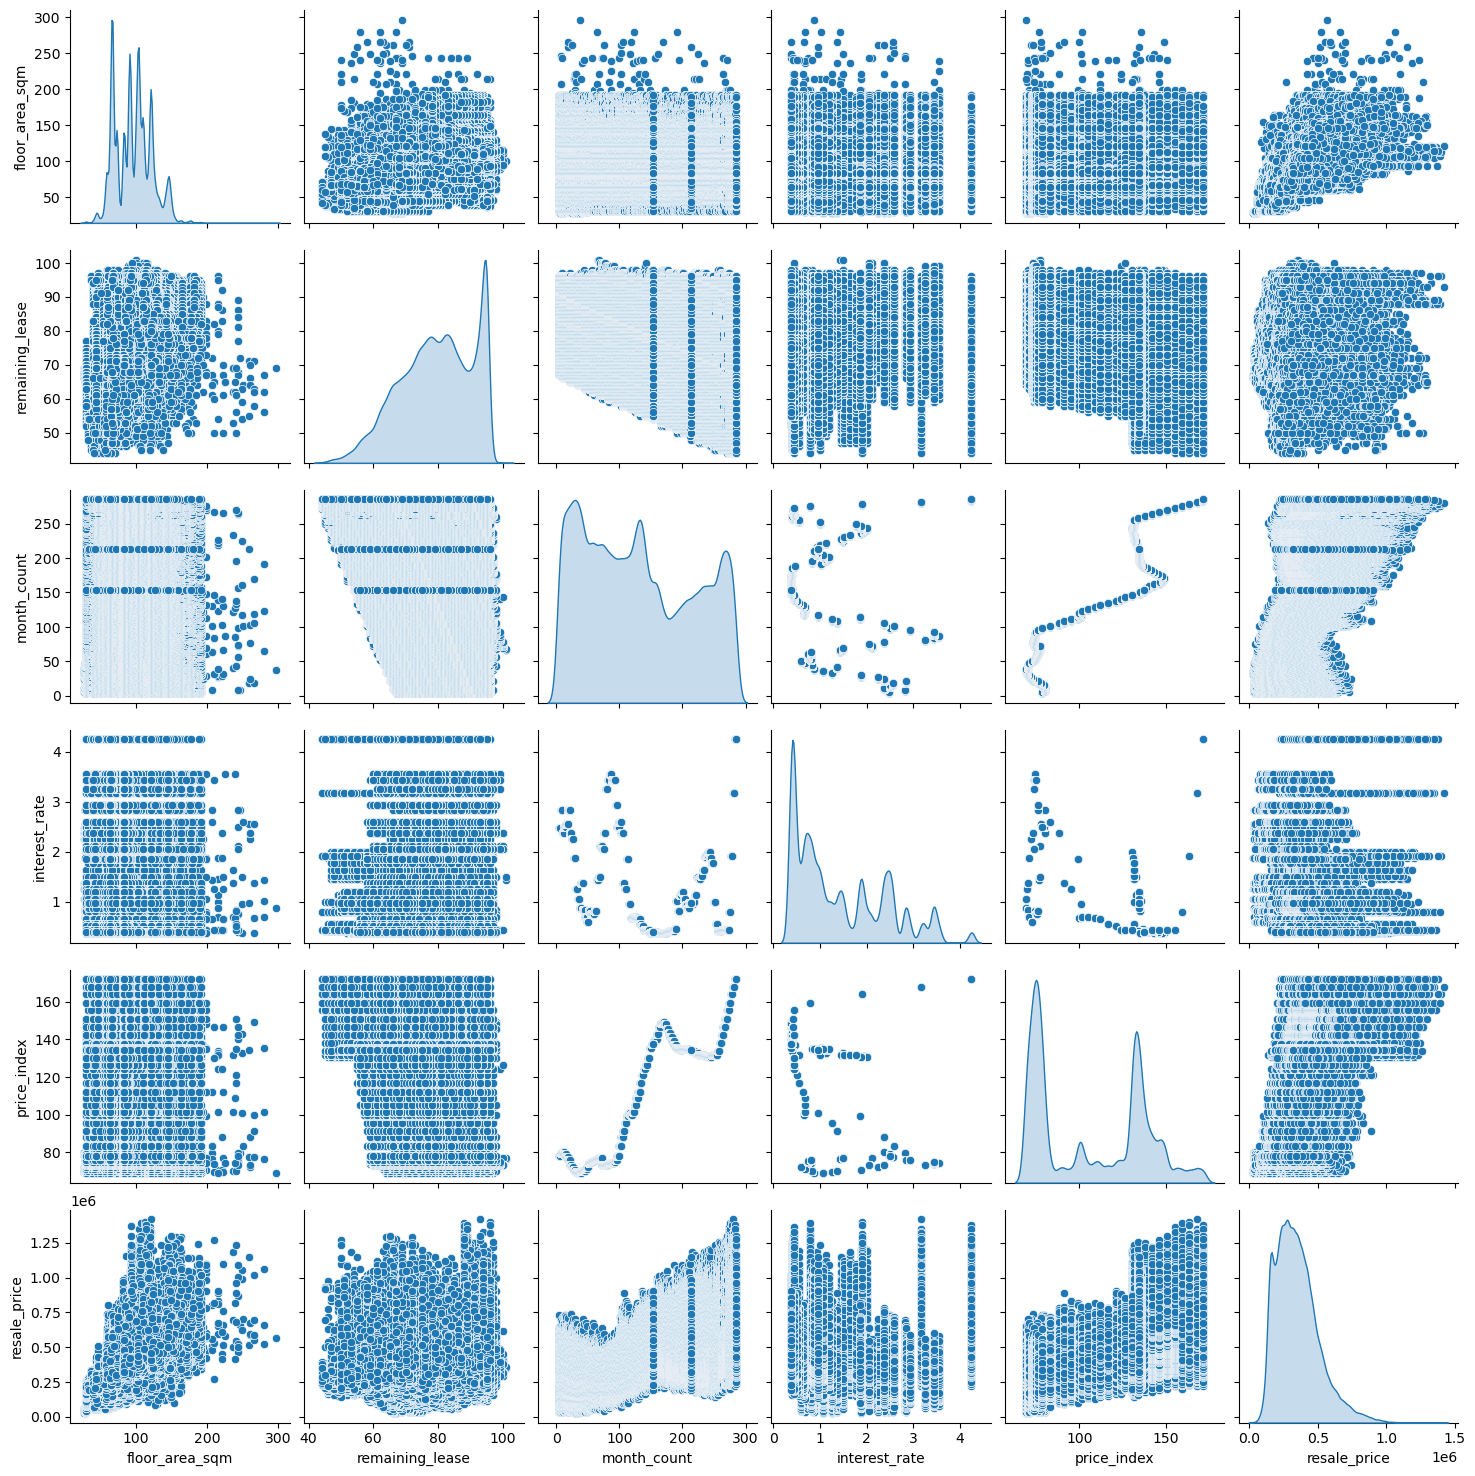

In [46]:
continuous_var = all_data[['floor_area_sqm', 'remaining_lease',
                           'month_count', 'interest_rate', 'price_index', 'resale_price']]

sns.pairplot(continuous_var, diag_kind='kde')
plt.show()

Consider to drop either 'price_index' or 'month_count' column since they seem to have strong relationship.

### Visualised relationship between 'resale_price' and discrete variables:

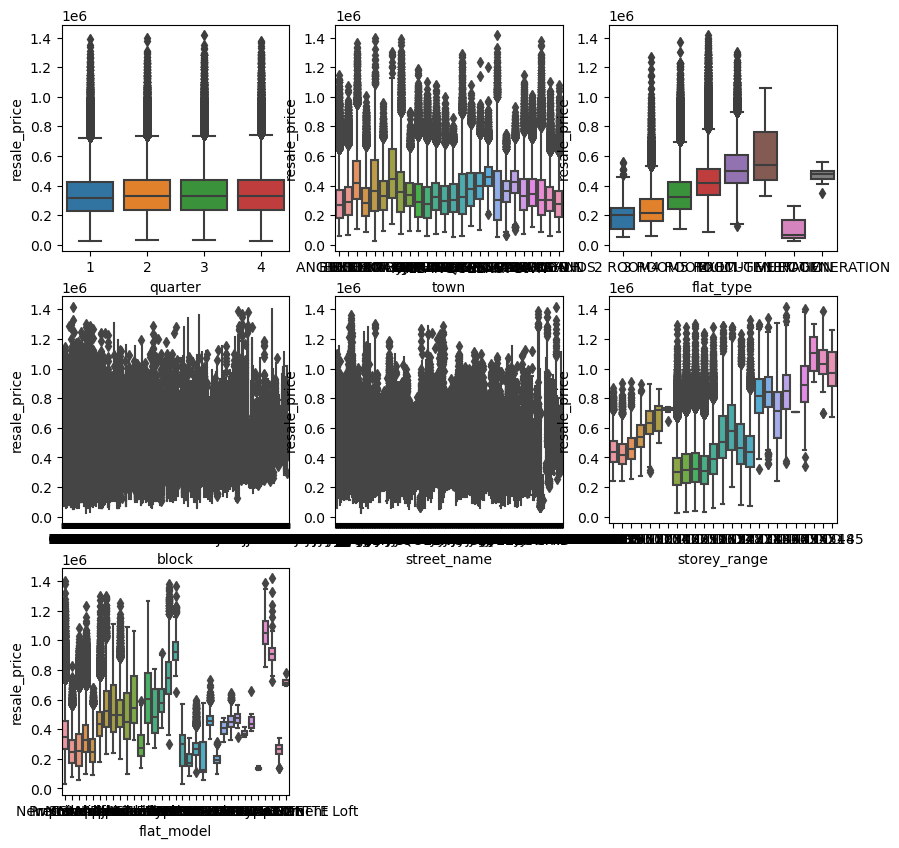

In [140]:
discrete_var = all_data[['town', 'flat_type', 'block', 'street_name', 'storey_range', 
                         'flat_model', 'resale_price', 'quarter']]

plt.figure(figsize=(10, 10))
plt.subplot(3,3,1)
sns.boxplot(x = 'quarter', y = 'resale_price', data = discrete_var)
plt.subplot(3,3,2)
sns.boxplot(x = 'town', y = 'resale_price', data = discrete_var)
plt.subplot(3,3,3)
sns.boxplot(x = 'flat_type', y = 'resale_price', data = discrete_var)
plt.subplot(3,3,4)
sns.boxplot(x = 'block', y = 'resale_price', data = discrete_var)
plt.subplot(3,3,5)
sns.boxplot(x = 'street_name', y = 'resale_price', data = discrete_var)
plt.subplot(3,3,6)
sns.boxplot(x = 'storey_range', y = 'resale_price', data = discrete_var)
plt.subplot(3,3,7)
sns.boxplot(x = 'flat_model', y = 'resale_price', data = discrete_var)
# plt.subplot(3,3,8)
# sns.boxplot(x = 'flat_model', y = 'floor_area_sqm', data = discrete_var)
plt.show()

- Consider to drop 'quarter' since the 'resale_price' patterns are visually similar across the quarters.
- Consider to remove 'block' and 'street_name' as 'town' seems to provide more meaningful location information
The remaining data after dropping additional columns is as followed:

In [394]:
all_data = all_data.drop(['block', 'street_name', 'quarter', 'price_index'], axis=1)
all_data.columns

Index(['month', 'town', 'flat_type', 'storey_range', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease',
       'year', 'month_count', 'Ask Price'],
      dtype='object')

In [405]:
# Clean the categorical variables:
categorical_var = ['town', 'flat_type', 'storey_range', 'flat_model']
for col in categorical_var:
    all_data[col]= all_data[col].apply(lambda x: x.replace(' ', '_'))
    all_data[col]= all_data[col].apply(lambda x: x.lower())

In [406]:
all_data.head(5)

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,month_count,Ask Price
0,3,ang_mo_kio,2_room,06_to_10,45.0,improved,1986,250000.0,73,2012,156,0.39494
1,3,ang_mo_kio,2_room,01_to_05,44.0,improved,1980,265000.0,67,2012,156,0.39494
2,3,ang_mo_kio,3_room,06_to_10,68.0,new_generation,1980,315000.0,67,2012,156,0.39494
3,3,ang_mo_kio,3_room,01_to_05,67.0,new_generation,1984,320000.0,71,2012,156,0.39494
4,3,ang_mo_kio,3_room,06_to_10,67.0,new_generation,1980,321000.0,67,2012,156,0.39494


In [50]:
all_data[all_data['month_count'] < 221]['month_count'].nunique()

217

In [407]:
# Create dummy variables for categorical variables:
all_data['town']=all_data['town'].astype('category')
all_data['flat_type']=all_data['flat_type'].astype('category')
all_data['storey_range']=all_data['storey_range'].astype('category')
all_data['flat_model']=all_data['flat_model'].astype('category')

all_data = pd.get_dummies(all_data, drop_first=True)

In [415]:
all_data.groupby('month_count')['resale_price'].count()

month_count
4      5493
5      5209
6      3796
7      3783
8      3358
       ... 
281    2309
282    2581
283    1961
284    2132
285    2238
Name: resale_price, Length: 282, dtype: int64

In [419]:
len(all_data)

626866

### Training and testing different ML models to predict 'resale_price':

In [439]:
def model_fitting(x_train, y_train, x_test, y_test, x_forecast, y_forecast, model):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    r_2_train = metrics.r2_score(y_train, y_train_pred)
    mse_train = metrics.mean_squared_error(y_train, y_train_pred)
    print('MSE train: ', mse_train)
    print("R_squared of training set: ", r_2_train)

    y_test_pred = model.predict(x_test)
    mse_test = metrics.mean_squared_error(y_test_pred, y_test)
    r_2_test = metrics.r2_score(y_test_pred, y_test)
    
    y_forecast_pred = model.predict(x_forecast)
    r_2_predict = metrics.r2_score(y_forecast_pred, y_forecast)
    print("\n")
    print('MSE test: ', mse_test)
    print('R_squared of test set: ', r_2_test)
    print('R_squared of predict set: ', r_2_predict)
    
#     print('\nCoefficients: ', model.coef_)

    #Checking with plot:
    fig = plt.figure()
    plt.plot(y_test, y_test)
    plt.scatter(y_test, y_test_pred, alpha=.5)
    fig.suptitle("Prediction on resale_price" , fontsize = 20)              # Plot header 
    plt.xlabel('y_test', fontsize = 18)                          
    plt.ylabel('y_test_pred', fontsize = 16) 
    plt.show()
    
    fig2 = plt.figure()
    plt.plot(y_forecast, y_forecast)
    plt.scatter(y_forecast, y_forecast_pred, alpha=.5)
    fig.suptitle("Prediction on resale_price" , fontsize = 20)              # Plot header 
    plt.xlabel('y_forecast', fontsize = 18)                          
    plt.ylabel('y_forecast_pred', fontsize = 16) 
    plt.show()

#### Reserving 20% of the latest data as test data:

In [5]:
#Get group standardised data 
file_path = r'/Users/vince.dang/Desktop/SMU_MITB/CS610 Applied Machine Learning/Project/house_price'

new_data = pd.read_csv(file_path + '/complete_data.csv')

# Create dummy variables for categorical variables:
new_data['town'] = new_data['town'].astype('category')
new_data['flat_type'] = new_data['flat_type'].astype('category')
new_data['flat_model'] = new_data['flat_model'].astype('category')

new_data = pd.get_dummies(new_data, drop_first = True)

# Split train and test set:
# month_threshold = 221
month_threshold = 0.789285714285714 #normalised value

train_data = new_data[(new_data['month_count']<month_threshold)]
test_data = new_data[(new_data['month_count']>=month_threshold)]

print('Training size:', len(train_data))
print('Test size:', len(test_data))
print('Test ratio = %.2f' % (len(test_data)/len(new_data)))
x_train = train_data[train_data.columns.difference(['resale_price'])]
y_train = train_data['resale_price']
x_test = test_data[test_data.columns.difference(['resale_price'])]
y_test = test_data['resale_price'] 

Training size: 491724
Test size: 125054
Test ratio = 0.20


### GridSearch+CV

In [7]:
from sklearn.model_selection import GridSearchCV

GBR = ensemble.GradientBoostingRegressor()
parameters = {'n_estimators' : [100,300, 500]}
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 5, n_jobs=-1)
grid_GBR.fit(x_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(n_estimators=500)

 The best score across ALL searched params:
 0.8658537164536707

 The best parameters across ALL searched params:
 {'n_estimators': 500}


### R2 and RMSE by test month

 Test R squared by month=  [0.9106414401164644, 0.9064828898806674, 0.8916067882726048, 0.9032245522317246, 0.8862455532131068, 0.8910799527882031, 0.8843220957575837, 0.8893739214831746, 0.8860993507923464, 0.8730314044059647, 0.8705494182299808, 0.8659006097165096, 0.8745706446700834, 0.8699376560806111, 0.864140391669032, 0.8581971050689623, 0.8651549173973163, 0.8583694551505505, 0.8614953277824655, 0.8576463917355308, 0.8458823660408052, 0.8474562442482463, 0.8401313450386322, 0.8282383157981582, 0.8446399071360828, 0.8124916789681635, 0.8118089647790825, 0.8472874372753639, 0.823255710049691, 0.8258090719526863, 0.82386011581365, 0.8281267497008826, 0.8342358143944317, 0.8340019800803341, 0.8205399477644024, 0.8150111757736803, 0.8059424228860297, 0.740137832911573, 0.7158612953025618, 0.6832254928642708, 0.6756237710835227, 0.599390470744009, 0.6170622360797735, 0.546580196680923, 0.49687882960977126, 0.47871380514619155, 0.3981029806263007, 0.38084866704796716, 0.34944140712685

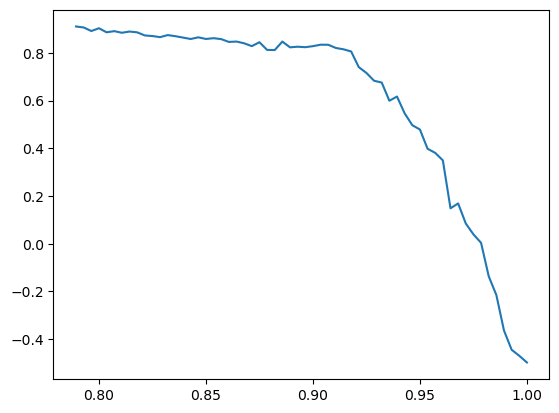

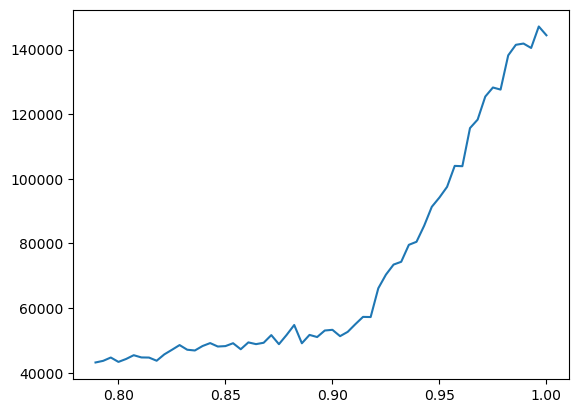

In [34]:
# Plotting R_squared of test set by month
month_list = x_test['month_count'].unique()
r_2_month = []
rmse_month = []

for curr_month in month_list:
    y_test_pred_month = y_test_pred[x_test['month_count'] == curr_month]
    y_test_month = y_test[x_test['month_count'] == curr_month]
    r_2_test = metrics.r2_score(y_test_pred_month, y_test_month)
    rmse_test = (metrics.mean_squared_error(y_test_pred_month, y_test_month))**(0.5)
    r_2_month.append(r_2_test)
    rmse_month.append(rmse_test)

print(' Test R squared by month= ', r_2_month)

#Checking with plot:
fig = plt.figure()
plt.plot(month_list, r_2_month)
plt.show()
plt.plot(month_list, rmse_month)
plt.show()

df = pd.DataFrame()
df['month'] = r_2_month
df['rmse'] = rmse_month
df['r_squared'] = r_2_month
file_name = r'/Users/vince.dang/Desktop/SMU_MITB/CS610 Applied Machine Learning/Project/house_price/r2_rmse.csv'
df.to_csv(file_name, encoding='utf-8', index=False)

### Feature importance (1) - default

In [24]:
df = pd.DataFrame()
df['feature'] = x_train.columns
df['feature_importance'] = gb_model.feature_importances_

print(df.sort_values('feature_importance', ascending=False).to_markdown())

|    | feature                           |   feature_importance |
|---:|:----------------------------------|---------------------:|
| 34 | month_count                       |          0.445213    |
| 32 | floor_area_sqm                    |          0.359808    |
|  0 | dist_city                         |          0.0960605   |
| 36 | storey                            |          0.0204246   |
| 35 | remaining_lease                   |          0.0192901   |
| 30 | flat_type_executive               |          0.0169784   |
| 33 | int_rate                          |          0.00816182  |
|  2 | dist_mrtlrt                       |          0.00683638  |
| 28 | flat_type_4_room                  |          0.00336222  |
| 51 | town_marine_parade                |          0.00199871  |
| 58 | town_tampines                     |          0.00183204  |
|  9 | flat_model_dbss                   |          0.00181202  |
| 38 | town_bishan                       |          0.00155989  |
| 23 | fla

### Feature importance (2) - R2 of Permutation

In [40]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.metrics import r2_score

columns = x_train.columns
group_town = []
group_flat_type = []
group_flat_model = []
group_names = []
groups = []
for i in range(len(columns)):
    if columns[i].startswith('town'):
        group_town.append(i)
    elif columns[i].startswith('flat_type'):
        group_flat_type.append(i)
    elif columns[i].startswith('flat_model'):
        group_flat_model.append(i)
    else:
        group_names.append(columns[i])
        groups.append(i)
group_names.append('town')
group_names.append('flat_model')
group_names.append('flat_type')
groups.append(group_town)
groups.append(group_flat_model)
groups.append(group_flat_type)
try_data = train_data.sample(1000)
try_x = try_data[try_data.columns.difference(['resale_price'])]
try_y = try_data['resale_price']

imp_vals, imp_all = feature_importance_permutation(
    predict_method=gb_model.predict, 
    X=try_x.to_numpy(),
    y=try_y.to_numpy(),
    metric=r2_score,
    num_rounds=5,
    feature_groups=groups,
    seed=1)
                      

/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fit

/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/vince.dang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fit